In [1]:
from audioFunctions import *
from binaryFunctions import *
from qam import *
from sequenceGenerators import *
from receiver import *
from to_import import *

In [3]:
CE_binary = fileToBinary('Data_Files/Holiday.txt')
binary = fileToBinary('Data_Files/homecoming.txt')

CE_symbols = qpsk(CE_binary)
symbols = qpsk(binary)

In [4]:
# So far this works the best at estimating the location... 
chirp_signal = Chirp(500,20500,0.5, volume = 80)

In [6]:
# For channel esimation (CE)

# ofdmSymbols(encoded_symbols, CP_length, DFT_length, max_freq_index=0)
CE_Time, CE_Freq, CE_Long = ofdmSymbols(CE_symbols, 2048, 2048)

In [14]:
# Prepare what to transmit for channel estimation 
CE_transmit = repeat_signal(CE_Time[0], 20)
known_freq = CE_Freq[0]

In [15]:
pause_after_chirp = 0.25
x = save_transmit( (chirp_signal, Pause(pause_after_chirp), CE_transmit, Pause(0.1)) )
print("Transmit signal is ", round(len(x)/fs, 2), " seconds")

Transmit signal is  2.71  seconds


In [40]:
sec = math.ceil(len(x)/fs) + 3
location = 'workdesk'
#y = record_and_save('recorded_data_' + location + '.wav', sec)
y = audioDataFromFile('recorded_data_' + location + '.wav')

In [41]:
# obtain only the time series we are interested in 
y_dash = removeChirpAndPause(y, chirp_signal, pause_after_chirp, plot = False, rng = 40)

In [42]:
#sliceData(time_data, timeshift, N, K, repeat)
CE_samples, CE_freq, remaining = sliceData(y_dash, 2000, 2048, 2048, 20)

freq = []
for sample in CE_samples:
    np.roll(sample, -1)
    freq.append( fft( np.roll(sample, -42) ) )
    
    
CE_time_adjusted_freq = np.array(freq)


/Users/kaijunge/Library/Python/3.7/lib/python/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


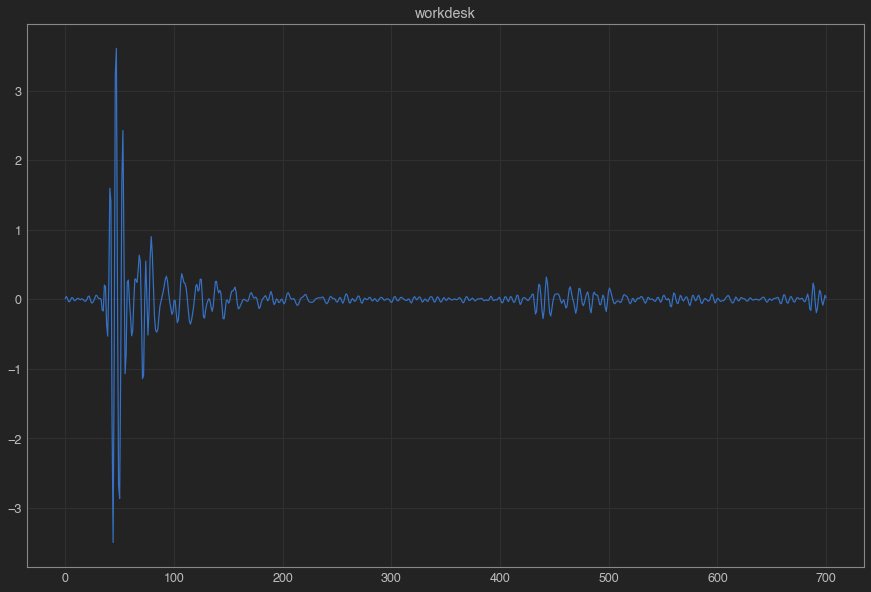

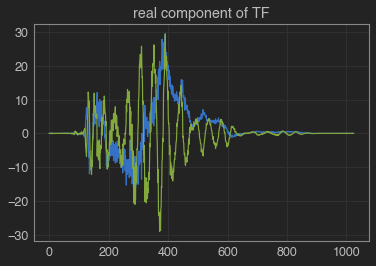

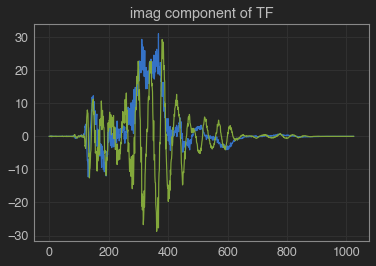

In [43]:
# getImpulseSimple(freq, known_freq, N, repeat)
impulse_simple, TF = getImpulseSimple(CE_freq, known_freq, len(CE_freq[0]), len(CE_freq))
impulse_simple_by_eye, TF_by_eye = getImpulseSimple(CE_time_adjusted_freq, known_freq, len(CE_freq[0]), len(CE_freq))

#plot_y(impulse_simple[1900:])

y_plotting = impulse_simple[:700]
plt.figure(2, figsize =(15,10))
x = np.linspace(0, len(y_plotting), len(y_plotting))
plt.plot(x, y_plotting)
plt.title(location)


plot_y(np.array(TF_by_eye)[:1024].real, title = "real component of TF")
plot_y(np.array(TF)[:1024].real)

plot_y(np.array(TF_by_eye)[:1024].imag, f =1 ,title = "imag component of TF")
plot_y(np.array(TF)[:1024].imag, f = 1)

In [44]:
def getPhase2(TF):
    Phase = [0]
    for i in range(1, int( len(TF)/2 )-1):
        Phase.append(cmath.phase(  TF[i]  ))
    
    return np.asarray(Phase)

In [46]:
ph_by_eye = getPhase2(TF_by_eye)
ph        = getPhase2(TF)

#plot_y(ph_by_eye)
#plot_y(ph, f= 1)